In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter

# 데이터 불러오기
metrics_df = pd.read_csv("C:/Users/User/Desktop/ch2025_data_items/ch2025_metrics_train.csv", parse_dates=["lifelog_date"])
merge_df2 = pd.read_csv("C:/Users/User/Desktop/ch2025_data_items/merge_df2.csv", parse_dates=["timestamp"])

# 날짜 통일
merge_df2['date'] = merge_df2['timestamp'].dt.date
metrics_df['date'] = metrics_df['lifelog_date'].dt.date

# Target 컬럼
targets = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']
common_features = ['wb_rssi', 'avg_heart_rate', 'm_usage_time', 'ww_rssi', 'avg_light',
                   'avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']

# 1. metrics_df를 먼저 train/test로 분할
train_metrics_df, test_metrics_df = train_test_split(metrics_df, test_size=0.2, random_state=42)

# 2. merge_df2에 train_metrics_df 조인하여 학습용 데이터 구성
train_df = pd.merge(merge_df2, train_metrics_df[['subject_id', 'date'] + targets], on=['subject_id', 'date'])
train_df = train_df.dropna(subset=targets).reset_index(drop=True)

# 3. 결과 저장용
pred_results = []

# 4. 타겟별 모델 훈련 및 예측
for target in targets:
    feat_col = f'feat_{target}'
    feature_cols = common_features + [feat_col]
    
    X = train_df[feature_cols]
    y = train_df[target]

    # 모델 학습
    model = XGBRegressor(random_state=42, n_jobs=-1)
    model.fit(X, y)

    # 테스트셋과 날짜 일치하는 merge_df2에서 예측용 입력 만들기
    pred_input_df = pd.merge(merge_df2, test_metrics_df[['subject_id', 'date']], on=['subject_id', 'date'])

    X_pred = pred_input_df[feature_cols]
    y_pred = model.predict(X_pred)
    pred_input_df[target] = y_pred

    # 날짜별 최빈값 추출
    mode_pred = (
        pred_input_df.groupby(['subject_id', 'date'])[target]
        .apply(lambda x: Counter(x.round(2)).most_common(1)[0][0])
        .reset_index()
    )

    pred_results.append(mode_pred)

# 5. 예측 결과 통합
final_pred_df = pred_results[0]
for i in range(1, len(targets)):
    final_pred_df = pd.merge(final_pred_df, pred_results[i], on=['subject_id', 'date'])

# 6. 실제값과 비교
compare_df = pd.merge(final_pred_df, test_metrics_df, on=['subject_id', 'date'], suffixes=('_pred', '_true'))

# 7. 성능 평가 (RMSE)
print("📊 RMSE by target:")
for target in targets:
    pred_col = f"{target}_pred"
    true_col = f"{target}_true"
    rmse = np.sqrt(mean_squared_error(compare_df[true_col], compare_df[pred_col]))
    print(f"✅ {target}: RMSE = {rmse:.4f}")


📊 RMSE by target:
✅ Q1: RMSE = 0.5130
✅ Q2: RMSE = 0.5466
✅ Q3: RMSE = 0.5169
✅ S1: RMSE = 0.6961
✅ S2: RMSE = 0.4648
✅ S3: RMSE = 0.4301


c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: Q1
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59        63
           1       0.59      0.57      0.58        63

    accuracy                           0.59       126
   macro avg       0.59      0.59      0.59       126
weighted avg       0.59      0.59      0.59       126

Confusion Matrix:
[[38 25]
 [27 36]]
Accuracy: 0.5873


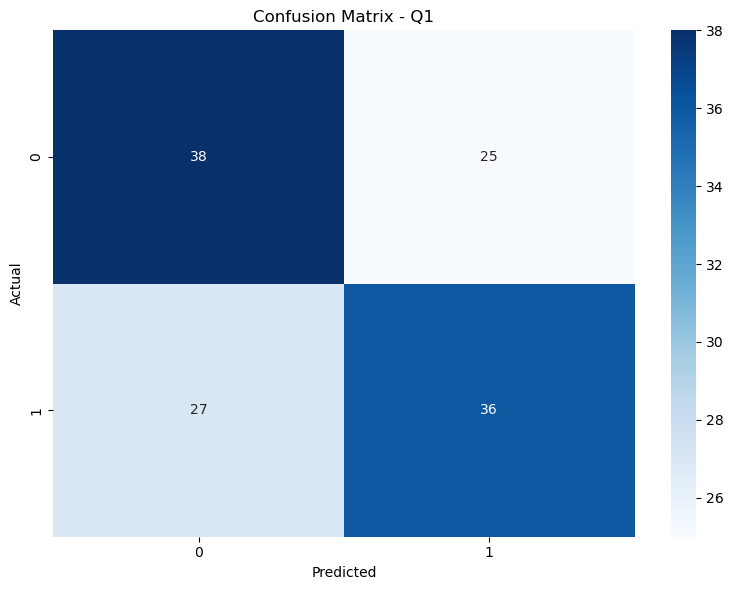

c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: Q2
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.60      0.59        55
           1       0.68      0.67      0.67        69

    accuracy                           0.64       124
   macro avg       0.63      0.63      0.63       124
weighted avg       0.64      0.64      0.64       124

Confusion Matrix:
[[33 22]
 [23 46]]
Accuracy: 0.6371


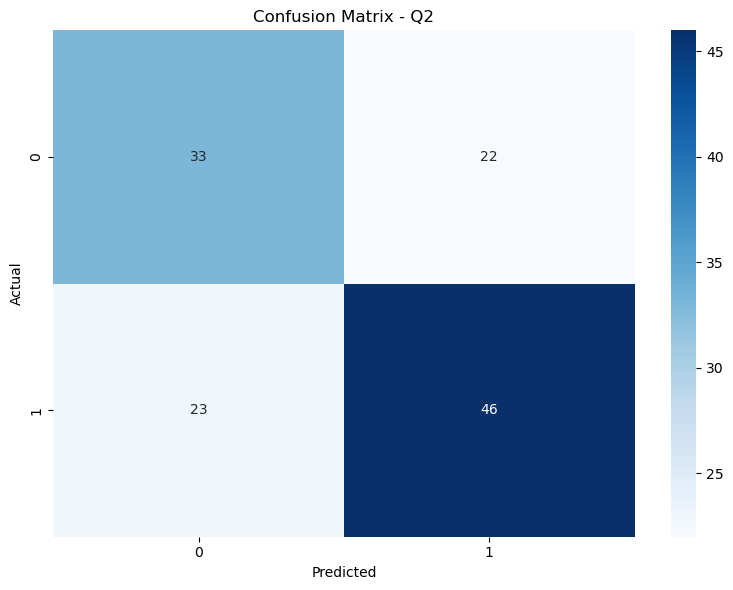

c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: Q3
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.44      0.51        52
           1       0.68      0.81      0.74        78

    accuracy                           0.66       130
   macro avg       0.65      0.62      0.63       130
weighted avg       0.65      0.66      0.65       130

Confusion Matrix:
[[23 29]
 [15 63]]
Accuracy: 0.6615


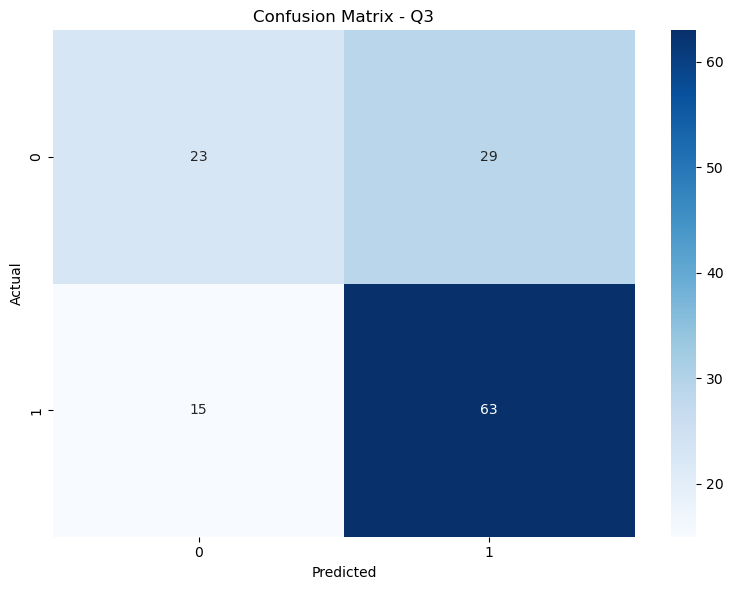

c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: S1
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.34      0.38        35
           1       0.56      0.69      0.62        65
           2       0.31      0.20      0.24        25

    accuracy                           0.50       125
   macro avg       0.43      0.41      0.41       125
weighted avg       0.47      0.50      0.48       125

Confusion Matrix:
[[12 19  4]
 [13 45  7]
 [ 3 17  5]]
Accuracy: 0.4960


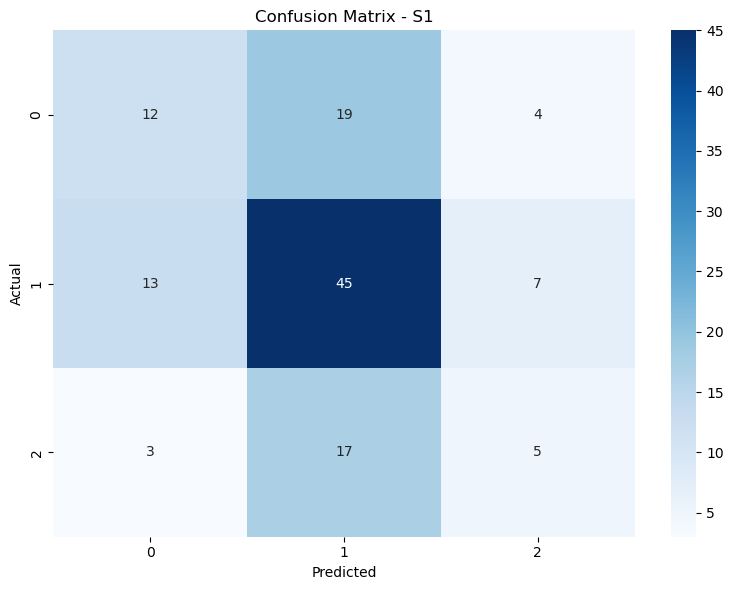

c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: S2
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.36      0.43        44
           1       0.71      0.83      0.77        84

    accuracy                           0.67       128
   macro avg       0.62      0.60      0.60       128
weighted avg       0.65      0.67      0.65       128

Confusion Matrix:
[[16 28]
 [14 70]]
Accuracy: 0.6719


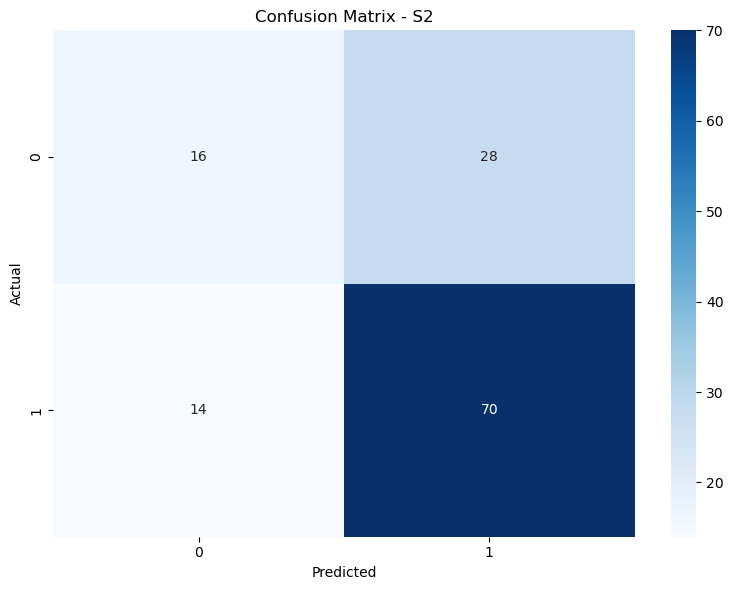

c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:14:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Target: S3
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.47      0.51        43
           1       0.74      0.80      0.77        82

    accuracy                           0.69       125
   macro avg       0.65      0.63      0.64       125
weighted avg       0.68      0.69      0.68       125

Confusion Matrix:
[[20 23]
 [16 66]]
Accuracy: 0.6880


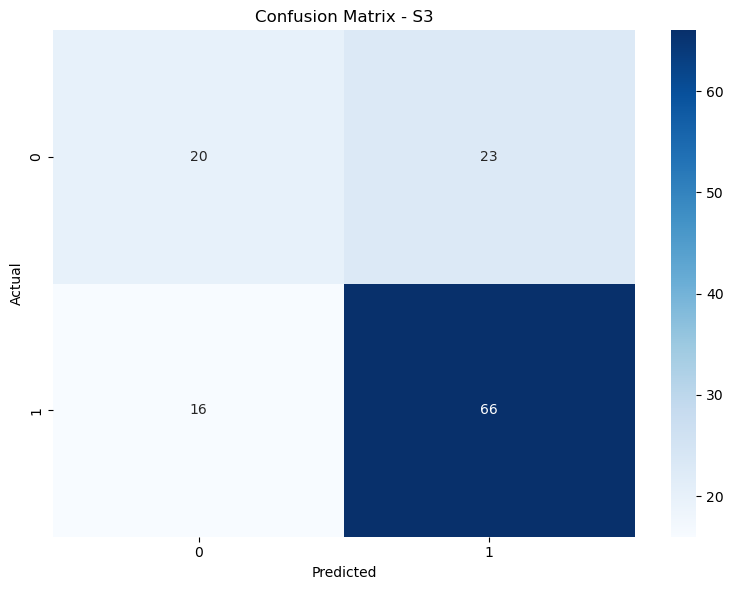

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ 데이터 로딩
metrics_df = pd.read_csv("C:/Users/User/Desktop/ch2025_data_items/ch2025_metrics_train.csv", parse_dates=["lifelog_date"])
merge_df2 = pd.read_csv("C:/Users/User/Desktop/ch2025_data_items/merge_df2.csv", parse_dates=["timestamp"])

# ✅ 날짜 정리
merge_df2["date"] = merge_df2["timestamp"].dt.date
metrics_df["date"] = metrics_df["lifelog_date"].dt.date

# ✅ 타겟 및 피처 설정
targets = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']
common_features = ['wb_rssi', 'avg_heart_rate', 'm_usage_time', 'ww_rssi', 'avg_light',
                   'avg_latitude', 'avg_longitude', 'avg_altitude', 'avg_speed']

# ✅ 결과 저장
results = []

# ✅ 각 타겟별 처리
for target in targets:
    feat_col = f'feat_{target}'

    # 1. metrics_df에서 target 있는 행만
    labeled_df = metrics_df[['subject_id', 'date', target]].dropna()
    
    # 2. 레이블을 정수형 범주로 변환
    labeled_df[target] = labeled_df[target].round(2).astype(str)
    unique_classes = sorted(labeled_df[target].unique())
    class_map = {label: i for i, label in enumerate(unique_classes)}
    inverse_map = {v: k for k, v in class_map.items()}
    labeled_df[target] = labeled_df[target].map(class_map)

    # 3. 학습/테스트 분할
    train_meta, test_meta = train_test_split(labeled_df, test_size=0.3, random_state=42, stratify=labeled_df[target])

    # 4. merge_df2와 join
    train_joined = pd.merge(merge_df2, train_meta, on=['subject_id', 'date'], how='inner')
    test_joined = pd.merge(merge_df2, test_meta, on=['subject_id', 'date'], how='inner')

    # 5. 분류 모델 훈련
    feature_cols = common_features + [feat_col]
    model = XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(train_joined[feature_cols], train_joined[target])

    # 6. 10분 단위 예측 후, 날짜별 최빈 클래스 결정
    test_joined['pred'] = model.predict(test_joined[feature_cols])

    daily_pred = (
        test_joined.groupby(['subject_id', 'date'])['pred']
        .agg(lambda x: Counter(x).most_common(1)[0][0])
        .reset_index()
        .rename(columns={'pred': 'predicted'})
    )

    # 7. 정답 매칭 및 원래 값 복원
    true_target = test_meta.rename(columns={target: 'actual'})
    compare_df = pd.merge(daily_pred, true_target, on=['subject_id', 'date'])
    compare_df['actual_label'] = compare_df['actual'].map(inverse_map)
    compare_df['predicted_label'] = compare_df['predicted'].map(inverse_map)

    # 8. 평가 결과 출력
    print(f"\n📊 Target: {target}")
    print("Classification Report:")
    print(classification_report(compare_df['actual'], compare_df['predicted'], target_names=[inverse_map[i] for i in range(len(unique_classes))]))
    print("Confusion Matrix:")
    print(confusion_matrix(compare_df['actual'], compare_df['predicted']))
    print(f"Accuracy: {accuracy_score(compare_df['actual'], compare_df['predicted']):.4f}")

    # (선택) Confusion matrix 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(compare_df['actual'], compare_df['predicted']), 
                annot=True, fmt="d", cmap="Blues",
                xticklabels=[inverse_map[i] for i in range(len(unique_classes))],
                yticklabels=[inverse_map[i] for i in range(len(unique_classes))])
    plt.title(f"Confusion Matrix - {target}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 9. 결과 저장
    compare_df['target'] = target
    results.append(compare_df)

# ✅ 전체 결과 결합 및 저장
final_df = pd.concat(results, ignore_index=True)
final_df.to_csv("classification_compare_df.csv", index=False)
